In [1]:
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import resample
import sys
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale

In [6]:
#df contains the data signal
df = pd.read_csv('our_dataset/_None_1627736256.csv') 
sample_rate = 10

In [7]:
#1st column contains the signal
raw = df.values[:, 1]
print(len(raw))
print(type(raw))

1798
<class 'numpy.ndarray'>


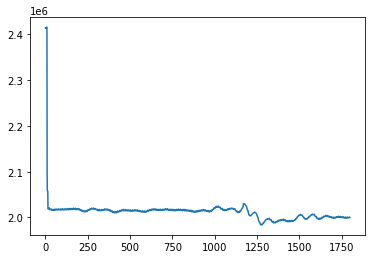

In [8]:
plt.plot(raw)
plt.show()

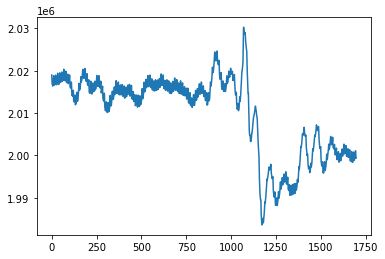

In [9]:
plt.plot(raw[100:])
plt.show()

In [10]:
#Divide signal in segments using window_size & overlap. Eliminate segments that has -
#i) a range that is at least 50% of range of the raw signal
#ii) a maximum that is 90% the raw signal’s maximum
#iii) a minimum that is the (minimum + 10%) of the raw signal

def Layer_1(raw, windowsize, overlap=0):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn

    #windowsize = 300
    #filtered = []
    final_filtered_data = []
    end = 0
    i = 0

    while (end+windowsize)<=len(raw):
        start = int((i * windowsize) -  (overlap * windowsize * i))
        end = int(start + windowsize)
        i = i + 1
        print('Range ', i, ': ')
        print('Start :', start)
        print('End :', end)
        sliced = raw[start:end]
        rng = np.max(sliced) - np.min(sliced)
        
        if ((rng >= (0.5 * global_range)) 
            or 
            (np.max(sliced) >= 0.9 * mx) 
            or 
            (np.min(sliced) <= mn )):

            print('Rejected!')
            #for x in sliced:
            #    filtered.append(0)
        else:
            print('Accepted!')
            filtered = []
            for x in sliced:
                filtered.append(x)
            final_filtered_data.append(filtered)
        #filtered.clear()
        print('\n')

    return final_filtered_data

In [11]:
#Divide signal in segments using window_size & overlap. Eliminate segments that has -
#any value more than the cutoff_val

def Layer_1_mod(raw, windowsize, overlap=0, cutoff_val=2500000):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn

    #windowsize = 300
    #filtered = []
    final_filtered_data = []
    end = 0
    i = 0

    while (end+windowsize)<=len(raw):
        start = int((i * windowsize) -  (overlap * windowsize * i))
        end = int(start + windowsize)
        i = i + 1
        print('Range ', i, ': ')
        print('Start :', start)
        print('End :', end)
        sliced = raw[start:end]
        max_val = np.max(sliced)
        
        if max_val>=cutoff_val:

            print('Rejected!')
            #for x in sliced:
            #    filtered.append(0)
        else:
            print('Accepted!')
            filtered = []
            for x in sliced:
                filtered.append(x)
            final_filtered_data.append(filtered)
        #filtered.clear()
        print('\n')

    return final_filtered_data

In [12]:
layer1_output = Layer_1(raw, 250, 0.6)
print(len(layer1_output))

Range  1 : 
Start : 0
End : 250
Rejected!


Range  2 : 
Start : 100
End : 350
Accepted!


Range  3 : 
Start : 200
End : 450
Accepted!


Range  4 : 
Start : 300
End : 550
Accepted!


Range  5 : 
Start : 400
End : 650
Accepted!


Range  6 : 
Start : 500
End : 750
Accepted!


Range  7 : 
Start : 600
End : 850
Accepted!


Range  8 : 
Start : 700
End : 950
Accepted!


Range  9 : 
Start : 800
End : 1050
Accepted!


Range  10 : 
Start : 900
End : 1150
Accepted!


Range  11 : 
Start : 1000
End : 1250
Accepted!


Range  12 : 
Start : 1100
End : 1350
Rejected!


Range  13 : 
Start : 1200
End : 1450
Rejected!


Range  14 : 
Start : 1300
End : 1550
Accepted!


11


In [13]:
#Passing through a Band-pass filter (0.5Hz - 4.00Hz) / (30bpm -240 bpm)

def Layer_2(layer1_output, minFreq=0.5, maxFreq=4.00, sample_rate=10.00):
    layer2_output = np.empty([len(layer1_output), len(layer1_output[0])])
    for i in range (len(layer1_output)):
        band_filtered = hp.filter_signal(np.array(layer1_output[i]), [minFreq, maxFreq], sample_rate=sample_rate, 
                                         order=3, filtertype='bandpass')
        layer2_output[i] = band_filtered
    return layer2_output

In [14]:
layer2_output = Layer_2(layer1_output)

In [15]:
print(layer2_output.shape)

(11, 250)


In [16]:
#Resample the signal (increase frequency)
#using freq_enhancer_factor = 10
def Layer_3(layer2_output, freq_enhancer_factor = 3.2, sample_rate=10.00):
    layer3_output = []
    for i in range (layer2_output.shape[0]):
        resampled_sig = resample(layer2_output[i], int(len(layer2_output[i]) * freq_enhancer_factor))
        layer3_output.append(resampled_sig)
    new_sample_rate = sample_rate * freq_enhancer_factor
    return (layer3_output, new_sample_rate)

In [17]:
(layer3_output, new_sample_rate) = Layer_3(layer2_output, freq_enhancer_factor=3.2, sample_rate=sample_rate)

In [18]:
print(len(layer3_output))
print(new_sample_rate)
print(len(layer3_output[0]))

11
32.0
800


In [19]:
#Segments are eliminated those hertpy can’t process due to ‘bad signal warning’
#Handled with try-except
#Returns the working_data too for later peak analysis
def Layer_4(layer3_output, new_sample_rate):
    layer4_output = []
    reject = 0
    wd_list = []
    for i in range (len(layer3_output)):
        #print(i)
        try:
            wd, m = hp.process(np.array(layer3_output[i]), sample_rate = new_sample_rate, bpmmin=30, bpmmax=240)
            layer4_output.append(layer3_output[i])
            wd_list.append(wd['binary_peaklist'])
            #hp.plotter(wd, m)
        except:
            #print('HeartPy couldn\'t process')
            reject = reject + 1
    print('Rejection Percentage: ', (reject*100.00)/len(layer3_output))
    return (layer4_output, wd_list)

In [20]:
layer4_output, wd_list = Layer_4(layer3_output, new_sample_rate)

Rejection Percentage:  0.0


C:\Python38\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [21]:
print(wd_list)

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0])]


In [22]:
#Check peak detection ratio. 
#Eliminate signals using a peak_acceptance_cutoff ratio.
#Currently using 70%

def Layer_5(layer4_output, wd_list, peak_acceptance_cutoff=0.7):
    layer5_output = []
    for i in range (len(layer4_output)):
        ratio = np.count_nonzero(wd_list[i]==1)/(len(wd_list[i]))
        print(i, ': ', ratio)
        if(ratio>=peak_acceptance_cutoff):
            layer5_output.append(layer4_output[i])
    return layer5_output

In [23]:
layer5_output = Layer_5(layer4_output, wd_list, 0.3)
print(len(layer5_output))
print(len(layer5_output[0]))

0 :  0.9565217391304348
1 :  0.9565217391304348
2 :  0.9583333333333334
3 :  0.96
4 :  0.96
5 :  0.9583333333333334
6 :  0.9583333333333334
7 :  0.9583333333333334
8 :  0.96
9 :  0.88
10 :  0.9615384615384616
11
800


In [24]:
#Downsample to desired new_freq (32Hz) + divide in segments of desired duration (25sec) 
#Standardize [0,1] the signal

def Layer_6(layer5_output, freq=32, sec=25, new_sample_rate=100.00):
    layer6_output = []
    length = freq * sec
    new_freq = (length*new_sample_rate)/(len(layer5_output[0]))
    for i in range(len(layer5_output)):
        resampled = resample(np.array(layer5_output[i]), int(len(layer5_output[i])*new_freq/new_sample_rate))
        for j in range(len(resampled)//length):
            start = j * length
            end = (j+1) * length
            #norm = np.linalg.norm(resampled)
            #normal_arr = resampled / norm
            #layer6_output.append(normal_arr)
            #print(resampled[start:end])
            resampled_scaled = minmax_scale(resampled[start:end], feature_range=(0, 1), axis=0, copy=False)
            #print(resampled_scaled)
            layer6_output.append(resampled_scaled)
            
    fin_layer6_output = np.array(layer6_output)
    return (fin_layer6_output, new_freq)

In [25]:
layer6_output, new_freq = Layer_6(layer5_output,  new_sample_rate=new_sample_rate)

In [26]:
print(layer6_output.shape)
print(new_freq)

(11, 800)
32.0


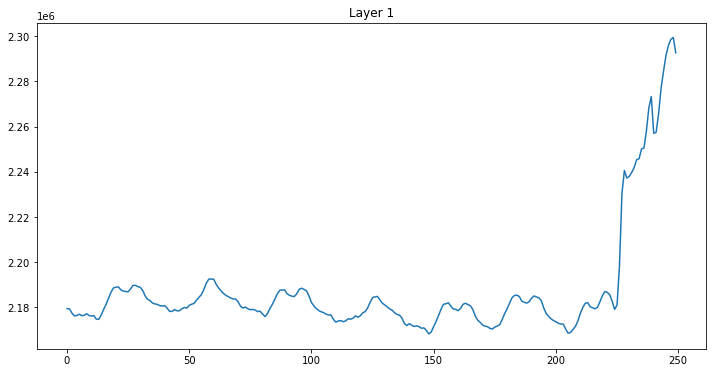

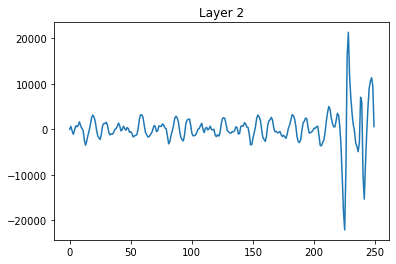

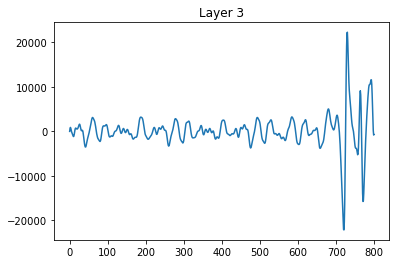

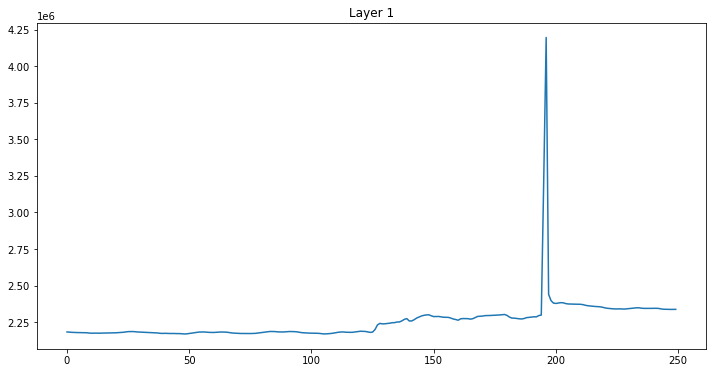

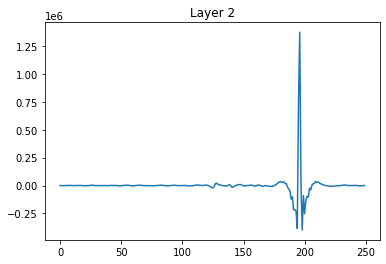

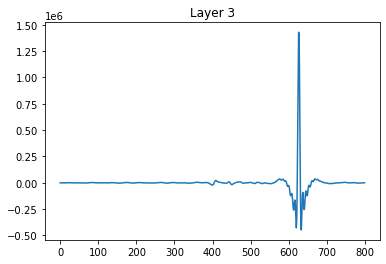

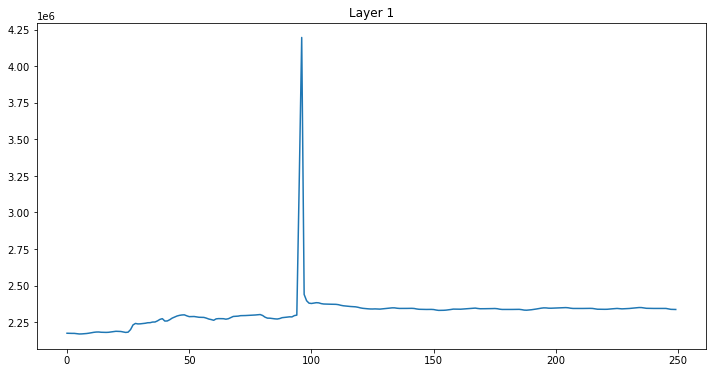

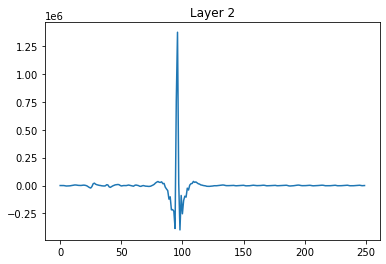

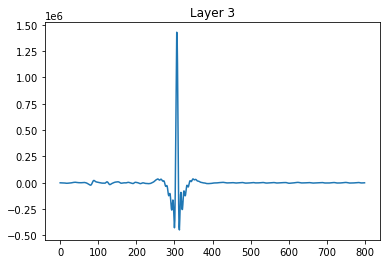

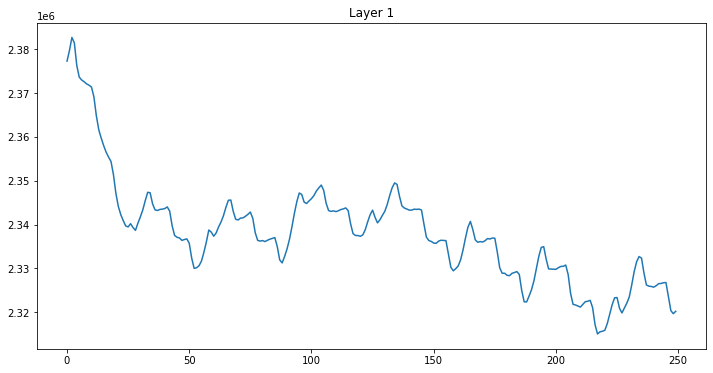

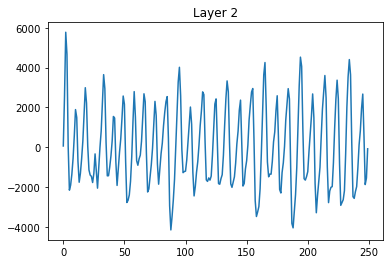

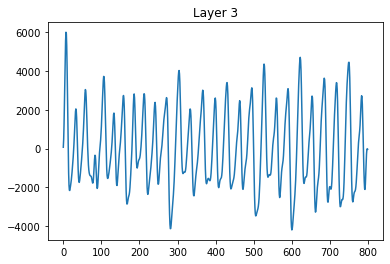

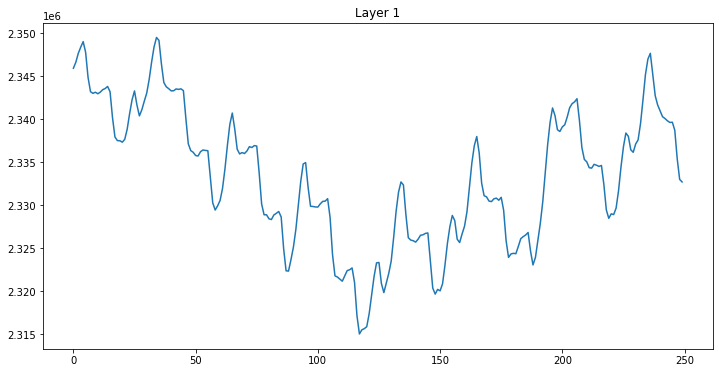

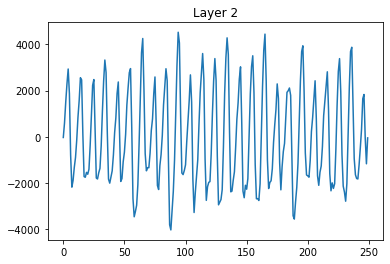

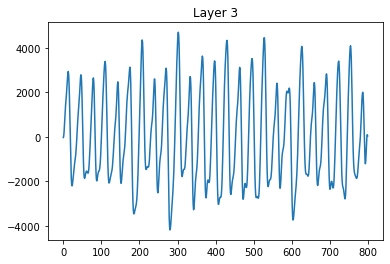

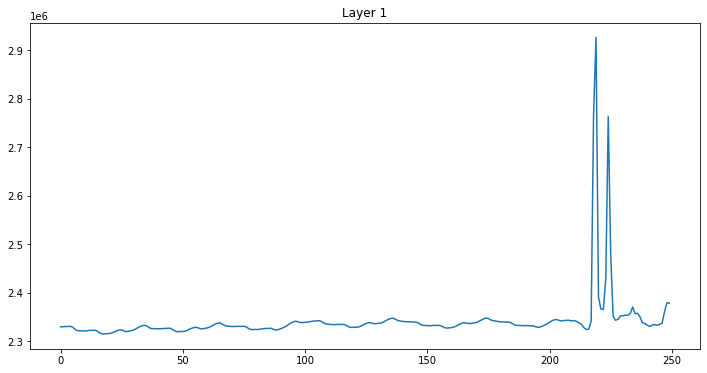

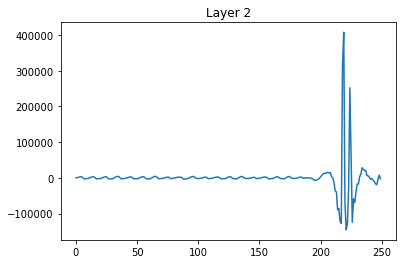

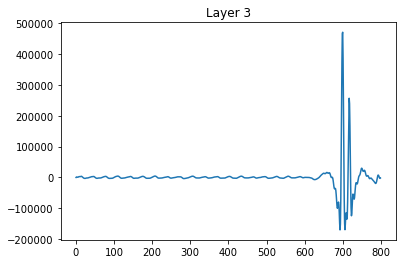

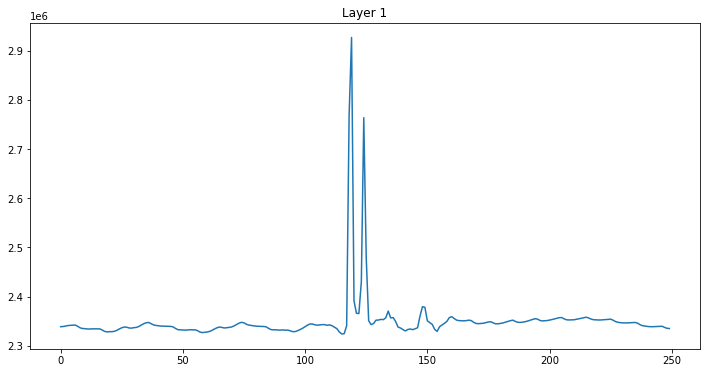

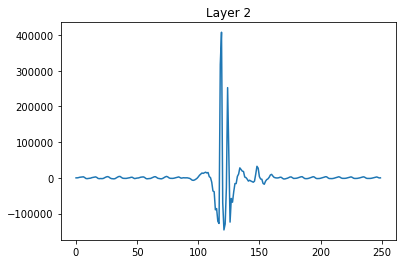

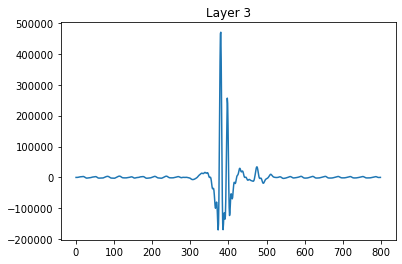

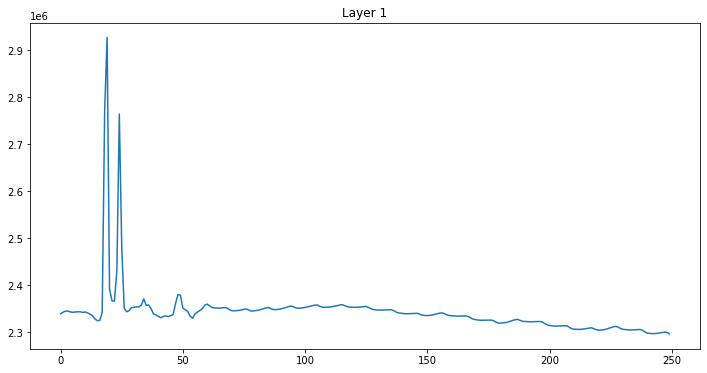

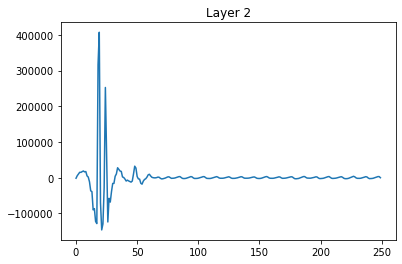

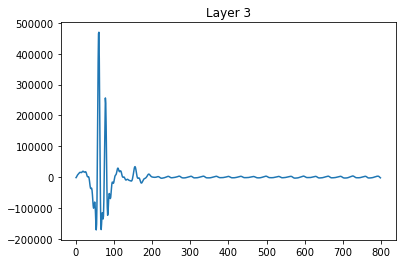

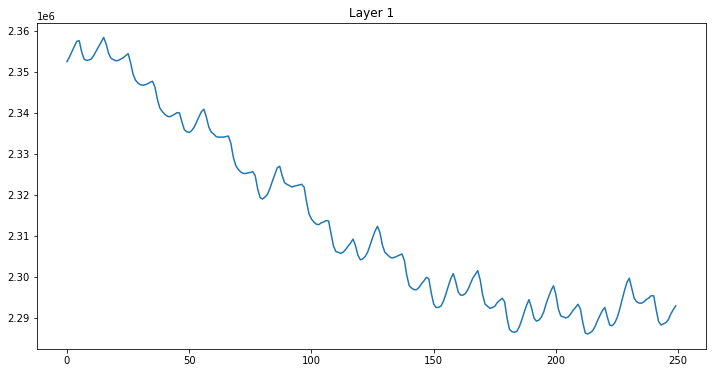

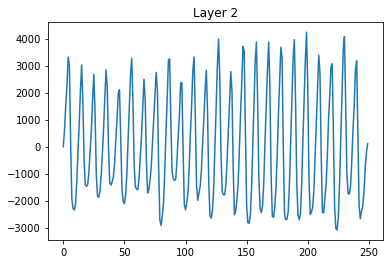

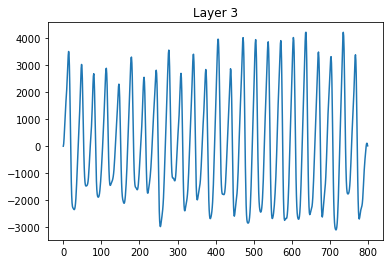

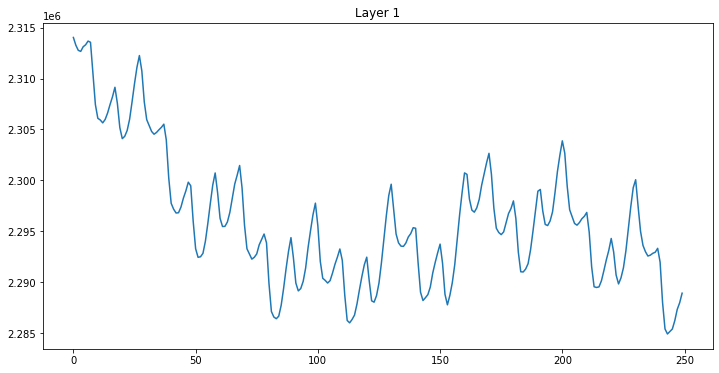

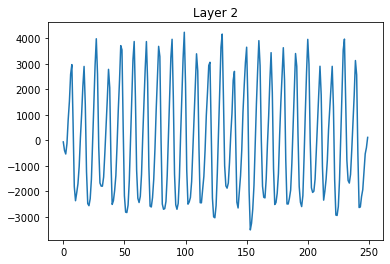

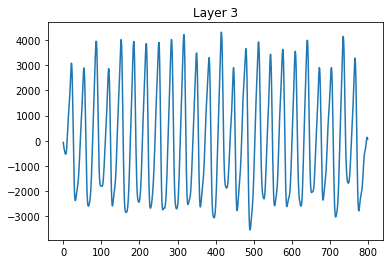

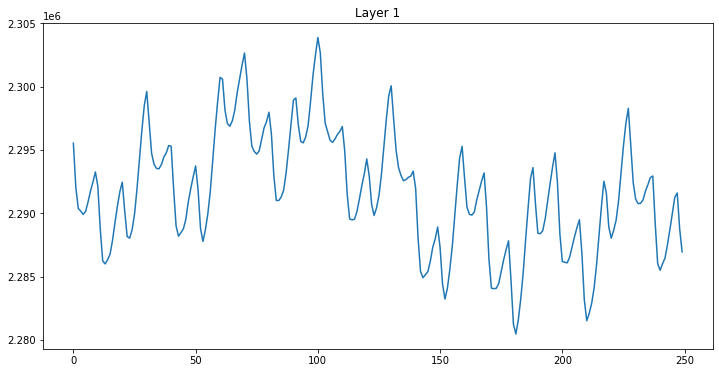

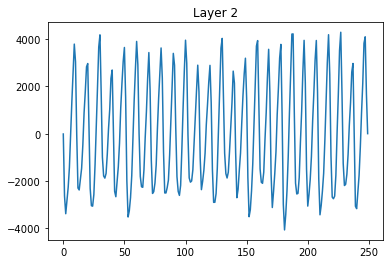

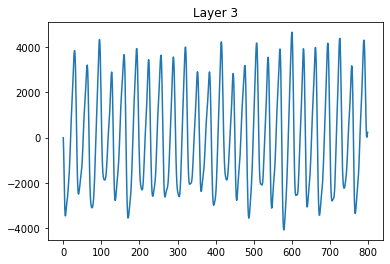

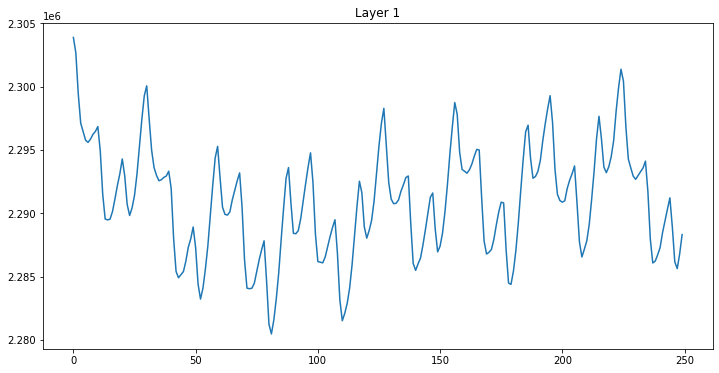

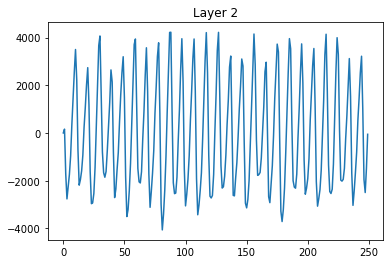

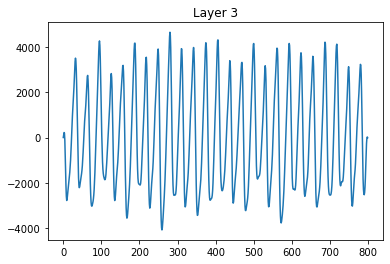

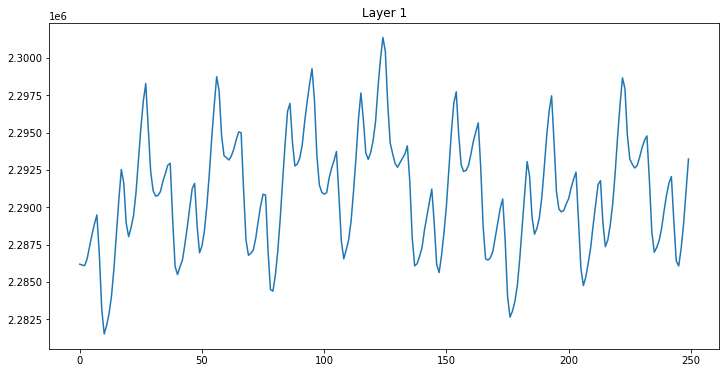

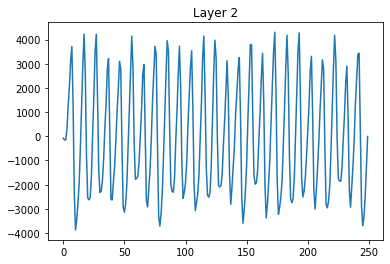

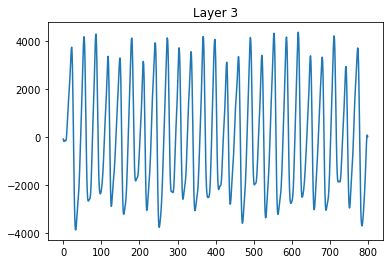

In [23]:
for i in range (len(layer1_output)):
    plt.figure(figsize=(12,6))
    plt.plot(layer1_output[i])
    plt.title('Layer 1')
    plt.show()
    plt.plot(layer2_output[i])
    plt.title('Layer 2')
    plt.show()
    plt.plot(layer3_output[i])
    plt.title('Layer 3')
    plt.show()

C:\Python38\lib\site-packages\numpy\ma\core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
C:\Python38\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy

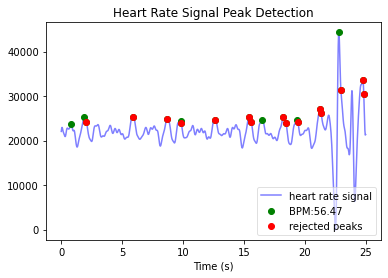

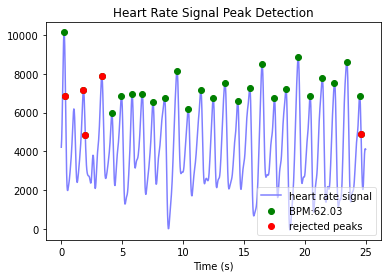

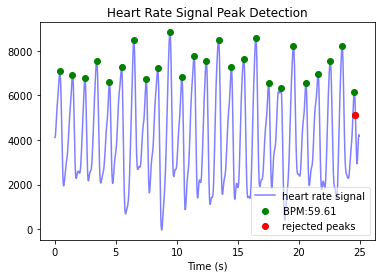

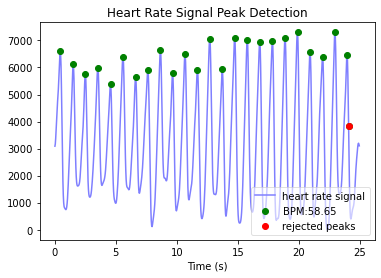

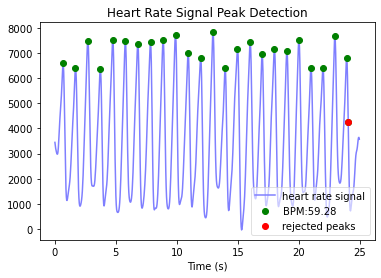

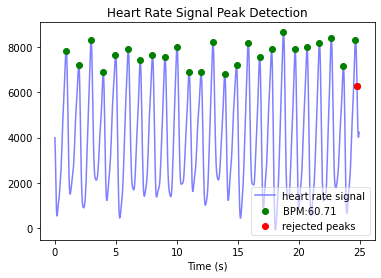

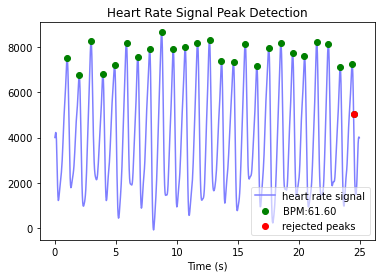

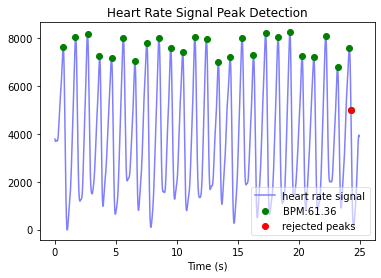

In [24]:
for i in range (len(layer4_output)):
    wd, m = hp.process(np.array(layer4_output[i]), sample_rate = new_sample_rate, bpmmin=30, bpmmax=240)
    hp.plotter(wd, m)

C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, whi

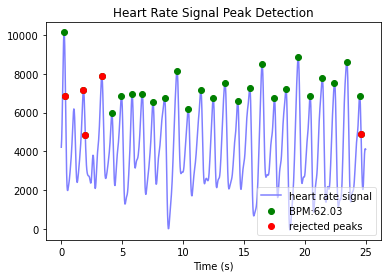

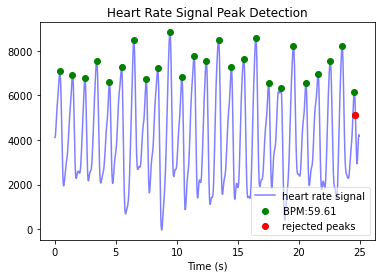

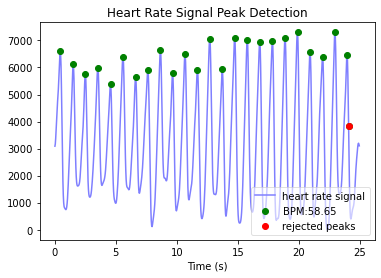

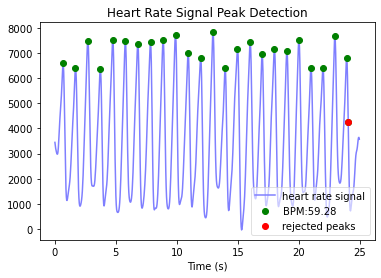

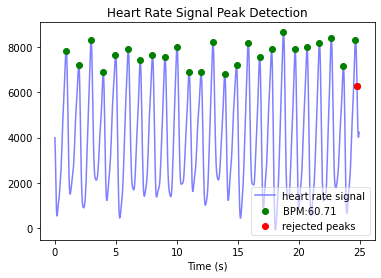

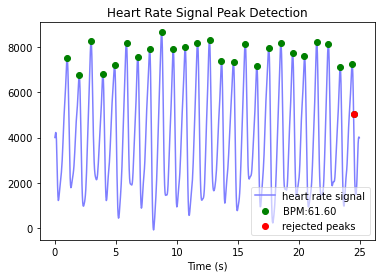

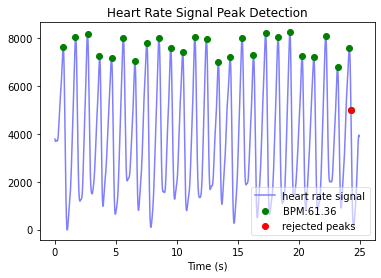

In [25]:
for i in range (len(layer5_output)):
    wd, m = hp.process(np.array(layer5_output[i]), sample_rate = new_sample_rate, bpmmin=30, bpmmax=240)
    hp.plotter(wd, m)

C:\Python38\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python38\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot 

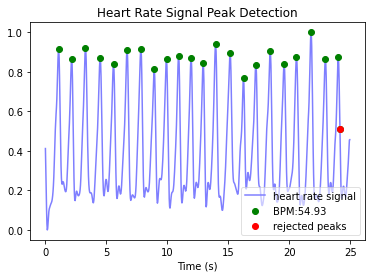

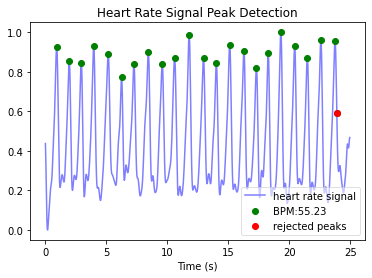

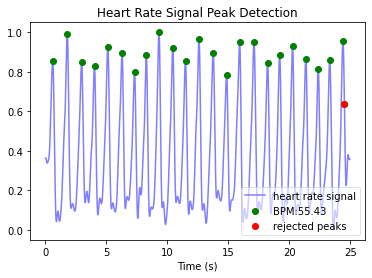

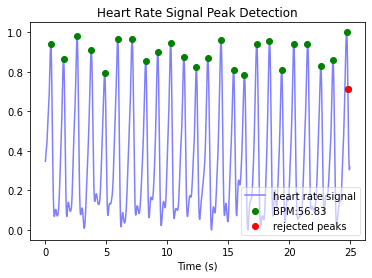

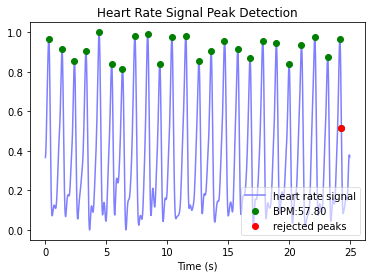

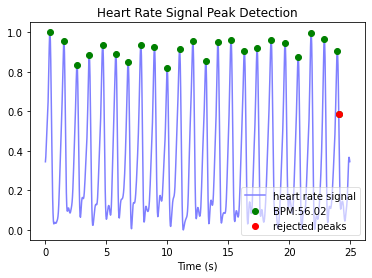

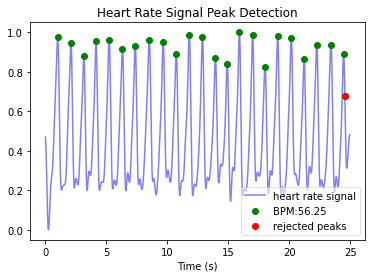

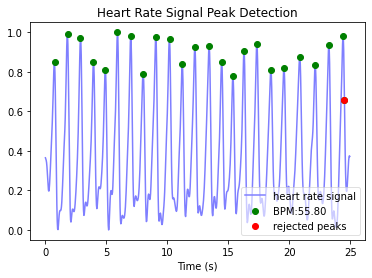

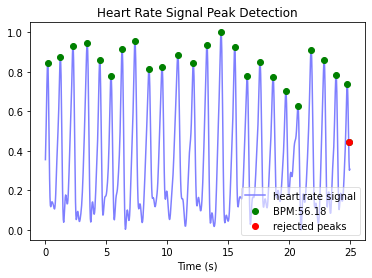

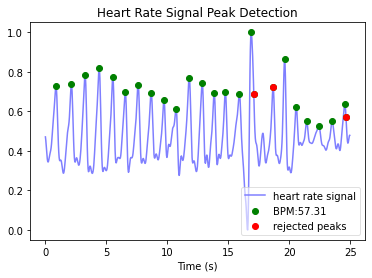

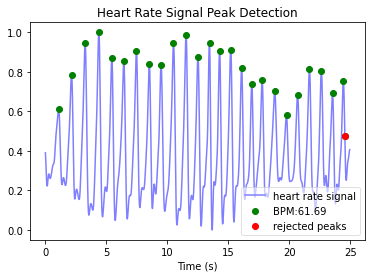

In [27]:
for i in range (layer6_output.shape[0]):
    wd, m = hp.process(layer6_output[i], sample_rate = new_freq, bpmmin=30, bpmmax=240)
    hp.plotter(wd, m)

In [28]:
final_output = np.copy(layer6_output)
final_output = np.reshape(final_output, (final_output.shape[0], final_output.shape[1], 1))
print(final_output.shape)
print(final_output)

(11, 800, 1)
[[[0.41163257]
  [0.32287823]
  [0.21011598]
  ...
  [0.42249417]
  [0.45527227]
  [0.45639247]]

 [[0.43712759]
  [0.35874108]
  [0.24663217]
  ...
  [0.43206245]
  [0.45761242]
  [0.46732024]]

 [[0.36282263]
  [0.36290249]
  [0.35663937]
  ...
  [0.35938654]
  [0.35523467]
  [0.35824572]]

 ...

 [[0.35559089]
  [0.43433443]
  [0.53123587]
  ...
  [0.34902314]
  [0.30189405]
  [0.30689744]]

 [[0.47061617]
  [0.45294287]
  [0.42858886]
  ...
  [0.46665678]
  [0.47660707]
  [0.47867634]]

 [[0.38997647]
  [0.35067608]
  [0.29822912]
  ...
  [0.38266355]
  [0.39966624]
  [0.40572987]]]


In [33]:
def preprocess_bayesbeat(raw, sample_rate=10):
    layer1_output = Layer_1(raw, 250, 0.6)
    layer2_output = Layer_2(layer1_output)
    layer3_output, new_sample_rate = Layer_3(layer2_output, freq_enhancer_factor=3.2,
                                            sample_rate=sample_rate)
    layer4_output, wd_list = Layer_4(layer3_output, new_sample_rate)
    layer5_output = Layer_5(layer4_output, wd_list, 0.3)
    layer6_output, new_freq = Layer_6(layer5_output, new_sample_rate=new_sample_rate)
    final_output = np.reshape(np.copy(layer6_output), (layer6_output.shape[0], layer6_output.shape[1], 1))
    if(len(layer1_output)!=0):
        accepted_sig_ratio = final_output.shape[0] / len(layer1_output)
    else:
        accepted_sig_ratio = 0
    print("Accepted Signal Ratio: ",accepted_sig_ratio)
    return final_output, layer6_output, new_freq, accepted_sig_ratio

In [34]:
def processed_sig_from_file(file_path):
    df = pd.read_csv(file_path)
    raw = df.values[:, 1]
    return preprocess_bayesbeat(raw)

In [35]:
(final_output, layer6_output, new_freq, accepted_sig_ratio) = processed_sig_from_file('our_dataset/_None_1627736256.csv')

Range  1 : 
Start : 0
End : 250
Rejected!


Range  2 : 
Start : 100
End : 350
Accepted!


Range  3 : 
Start : 200
End : 450
Accepted!


Range  4 : 
Start : 300
End : 550
Accepted!


Range  5 : 
Start : 400
End : 650
Accepted!


Range  6 : 
Start : 500
End : 750
Accepted!


Range  7 : 
Start : 600
End : 850
Accepted!


Range  8 : 
Start : 700
End : 950
Accepted!


Range  9 : 
Start : 800
End : 1050
Accepted!


Range  10 : 
Start : 900
End : 1150
Accepted!


Range  11 : 
Start : 1000
End : 1250
Accepted!


Range  12 : 
Start : 1100
End : 1350
Rejected!


Range  13 : 
Start : 1200
End : 1450
Rejected!


Range  14 : 
Start : 1300
End : 1550
Accepted!


Rejection Percentage:  0.0
0 :  0.9565217391304348
1 :  0.9565217391304348
2 :  0.9583333333333334
3 :  0.96
4 :  0.96
5 :  0.9583333333333334
6 :  0.9583333333333334
7 :  0.9583333333333334
8 :  0.96
9 :  0.88
10 :  0.9615384615384616
Accepted Signal Ratio:  1.0


C:\Python38\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


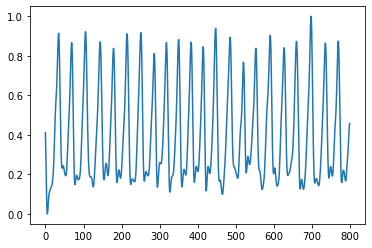

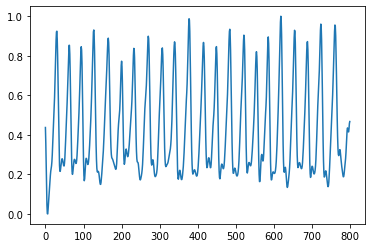

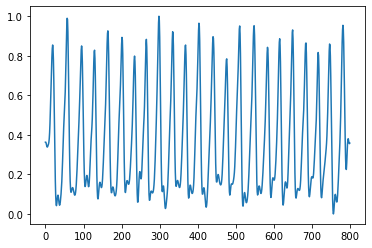

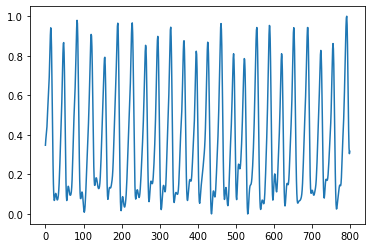

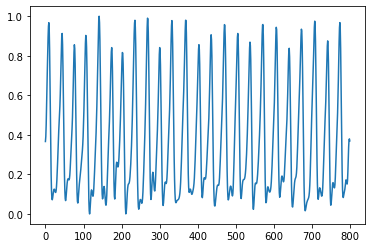

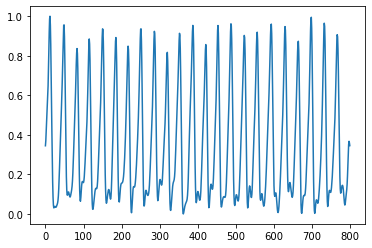

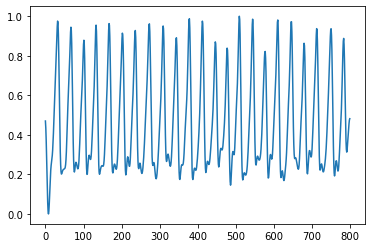

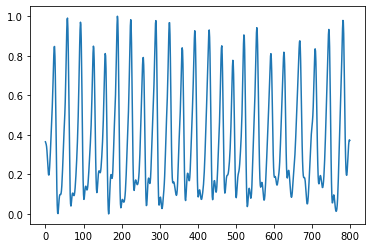

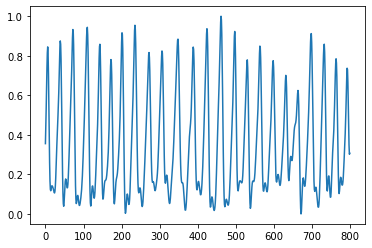

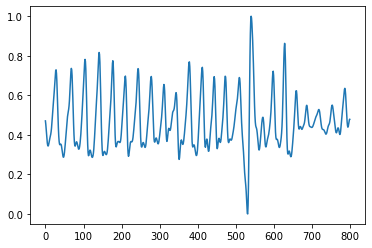

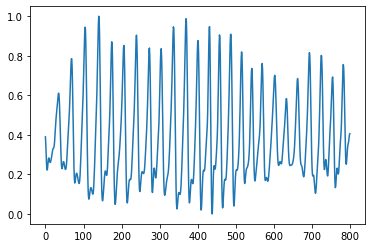

In [32]:
for i in range(final_output.shape[0]):
    plt.plot(final_output[i])
    plt.show()